# 이론
### 언어 모델
주어진 문장 이후 올 단어의 확률을 예측하는 모델.
- 예측 할 때에 모든 단어에 대해 확률을 매기며 **가장 확률이 높은 단어가 모델이 예측하는 다음 단어**가 된다.

즉, 주어진 문장을 보고 다음에 올 가장 그럴듯한 단어를 예측하는 모델이라고 볼 수 있다.   
잘 학습된 언어 모델로 **예측한 다음 단어로 새로운 시퀸스를 생성, 또 다음 단어를 예측하는 것을 반복**하여 새로운 문장을 생성해낼 수 있다.   
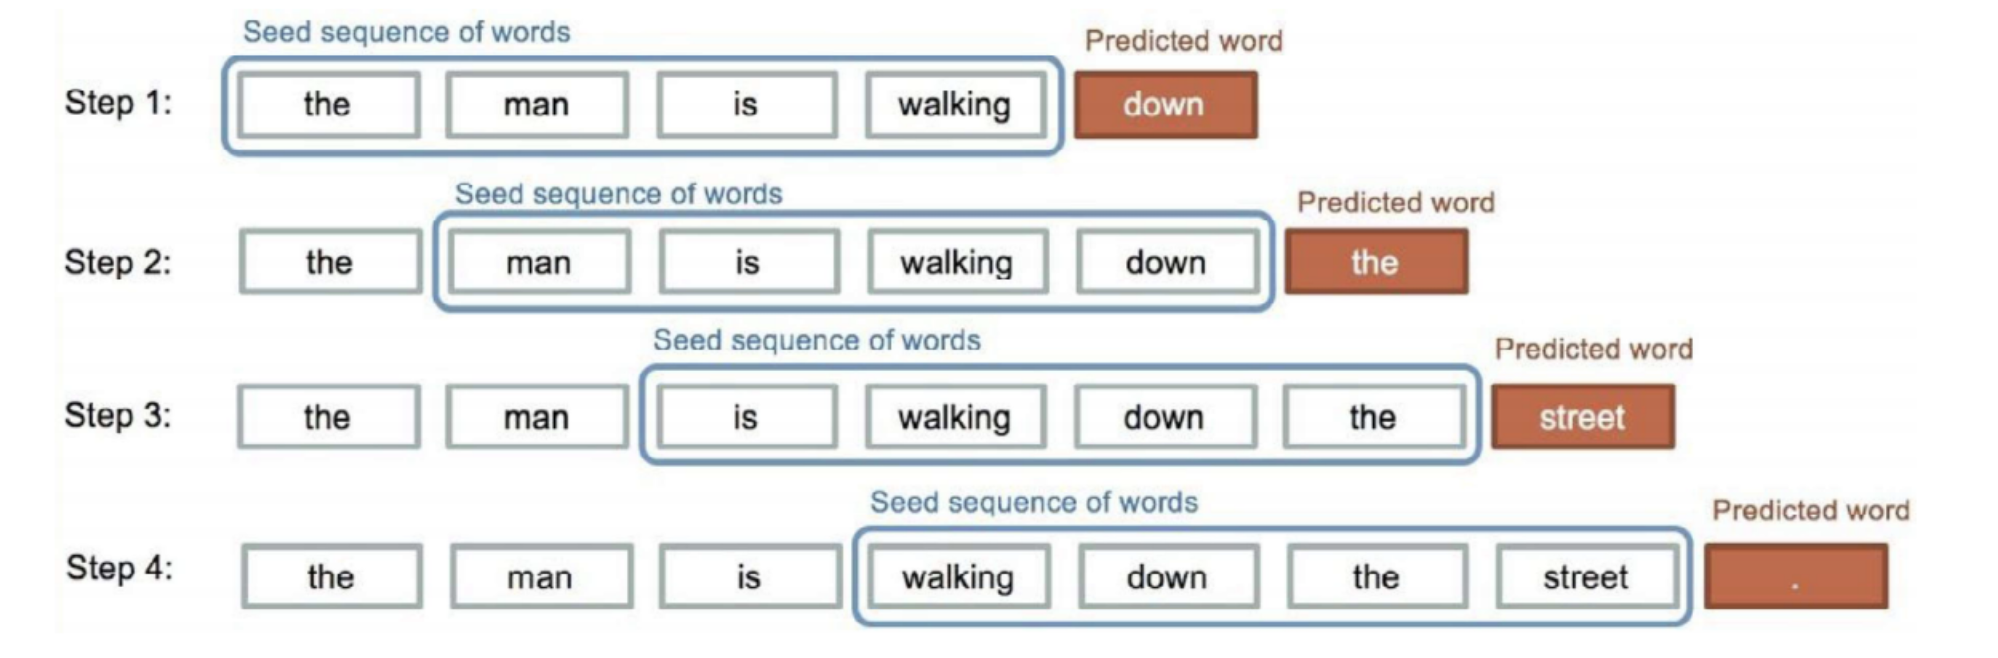   
- 언어 모델을 학습시킬 때 코퍼스만 있으면 위 그림처럼 계속해서 시퀸스를 만들어 데이터로 활용 가능하다. 즉, **별도 수작업을 통한 라벨링이 필요하지 않다.**
- 따라서 대규모의 **데이터셋에 대해 수행하기 좋은 특성**이 있고 컨텍스트를 고려해 다음 단어를 예측해야 하므로 **해당 언어에 관한 전반적 지식이 축적된 모델**이라고 볼 수 있다.
- 이에 연구자들은 컴퓨터 비전의 **전이학습**처럼 NLP에서도 언어 모델을 다른 세부 작업을 수행하기 위한 가중치 초기화 용도로 사용을 시작하였다. 이것을 목적으로 사용되는 언어모델을 **사전학습 언어모델, Pre-trained LM**이라고 한다.

### BERT
구글의 사전 사전 학습 LM으로 기성의 것들과 다른 학습 방식을 가진다.   
- Transformer를 활용한 모델 구조로, 다양한 작업에 대한 전이 학습의 성능이 탁월해 주목받게 되었으며 현재까지 후속 모델들이 널리 활용되고 있다.
- 하지만 GPT가 스케일을 키운 후 압도적인 성능이 나와 **스케일 == 성능** 공식이 성립되었다.
- 이에 주요 거대 기업들은 가능한 큰 스케일의 LM을 개발하려 경쟁중이다. 이런 거대 모델들을 LLM(Large Language Model)이라고 한다.

BERT는 사전학습 시 기존 모델들의 단방향 학습을 보완하기 위해 **랜덤으로 단어를 마스킹하고 주변 컨텍스트를 통해 예측**하게 하여 양방향 분석을 수행했다.
- 이러한 LM들을 **masked language model(MLM)이라 한다.

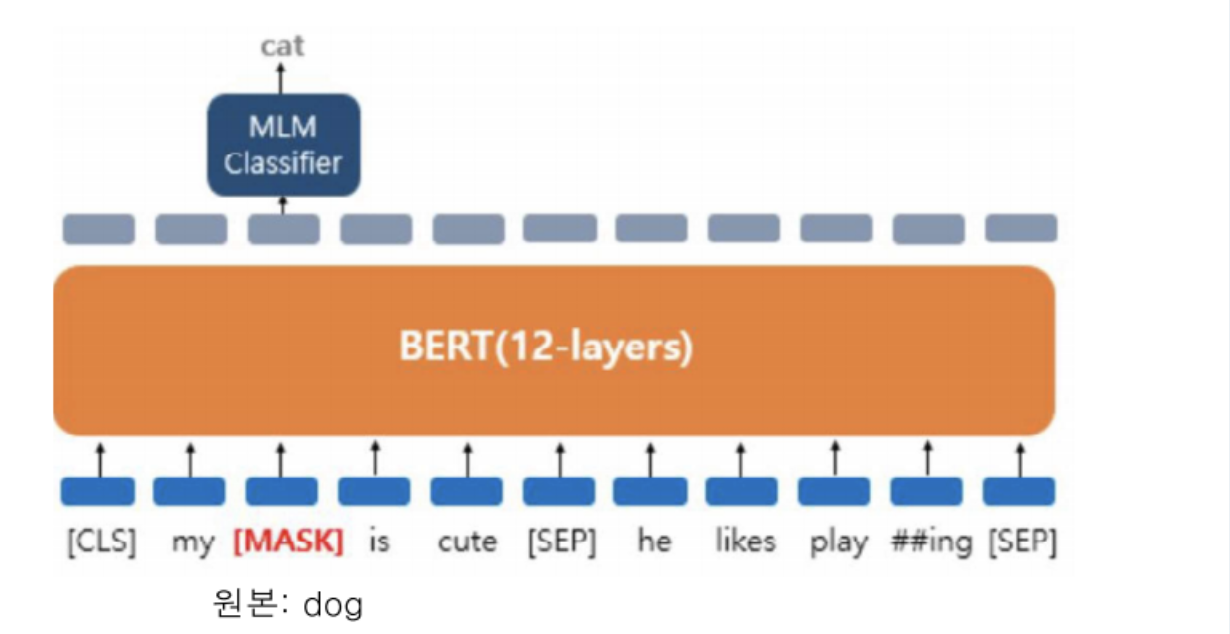

##### BERT fine-tuning
- 사전학습 모델을 실제 세부 문제에 활용하는 단계를 일컫는 말이다.
- 그림과 같이 Transformer의 출력값들 중 첫 토큰에 전결합층을 연결 후 분류를 수행한다.
- 사전학습 및 fine-tuning 모두 BERT의 입력값 중 맨 첫 토큰은 분류 목적의 특수 토큰인 [CLS]가 사용되었다.

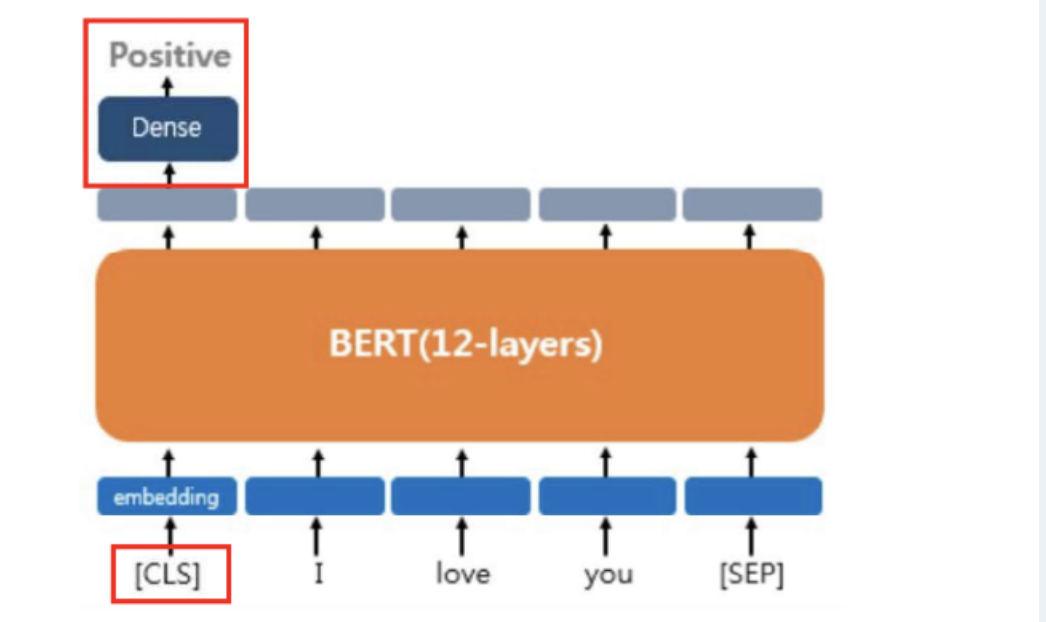

#### 텍스트 태깅 fine-tuning 구조
- 단어의 품사 등을 태깅하는 작업의 경우는 각 단어의 index에 해당하는 출력 토큰들에 각각 전결합층을 연결해 태깅을 수행한다.

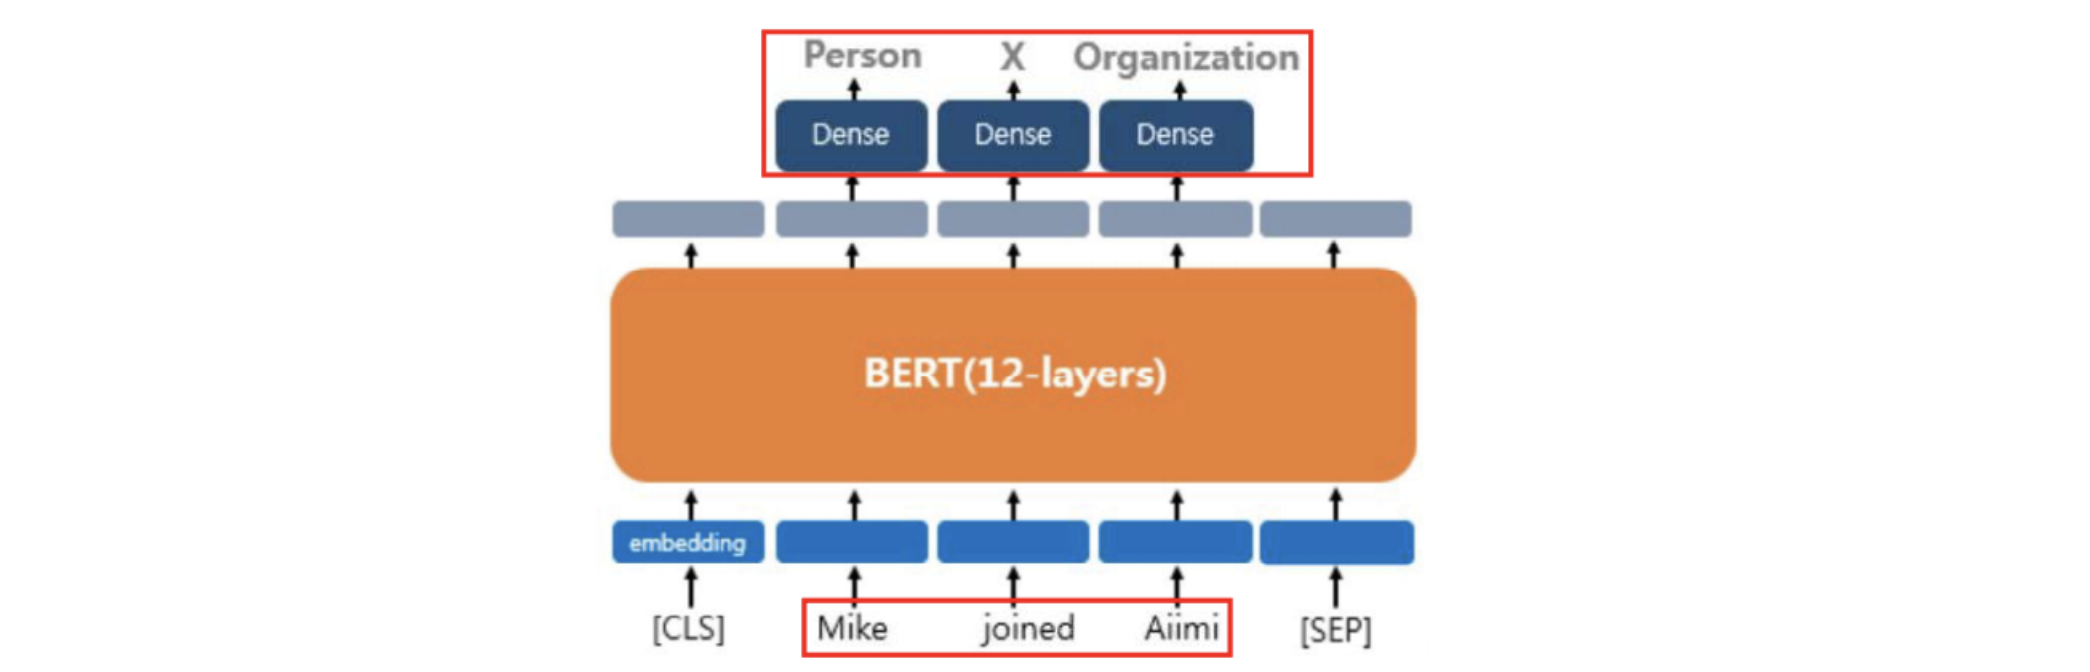   
#### 텍스트 페어에 대한 분류 fine-tuning 구조
- [SEP] 토큰을 통해 각 문장을 구분하고 따라서 두 문장을 입력하고 분류를 수행할 수 있다.

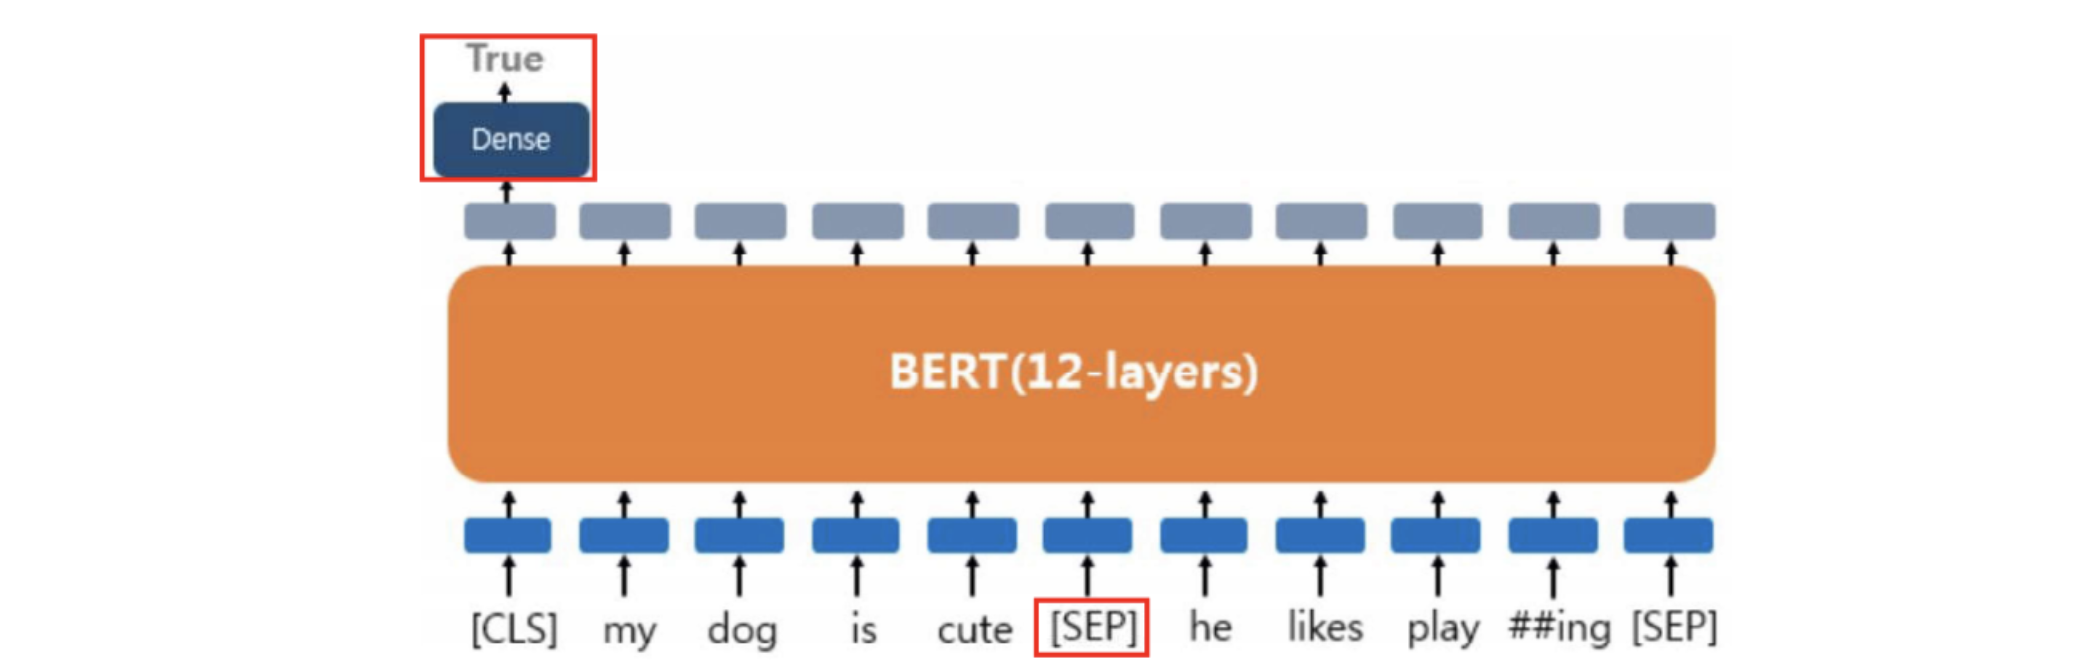

# 구현

BERT 활용을 위해 Transformers를 설치하고 데이터셋을 로드한다.

In [1]:
import pandas as pd
import re
import urllib.request
import numpy as np

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x10f268c90>)

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how = 'any') # Null 값 제거

test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how = 'any') # Null 값 제거

**전처리 해주지 않으면 토큰화 과정에서 에러가 발생함을 확인**하여 학습 데이터와 같은 형식으로 일괄 전처리를 진행한다.
- 실제 상황을 가정한다면 테스트 데이터는 매 입력 전마다 전처리하여 빈 입력이 되면 스킵하는 것으로 처리한다.

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

/Users/daejin/.pyenv/versions/3.11.1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
sampled_train_data = train_data[:5000]
sampled_test_data = test_data[:5000]

train_tokens = tokenizer(list(sampled_train_data['document']), padding='max_length', truncation=True, return_tensors="pt", add_special_tokens=True)
test_tokens = tokenizer(list(sampled_test_data['document']), padding='max_length', truncation=True, return_tensors="pt", add_special_tokens=True)

print(tokenizer.convert_ids_to_tokens(train_tokens['input_ids'][0]))

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

- 한국어 pre-trained BERT 모델이 여러 가지가 있으나 klue/bert-base를 활용해 실습을 진행한다.
- **학습 속도 및 메모리 문제로 인해 데이터셋은 10000개 까지만 샘플링**하여 활용한다.
- BERT는 word piece라는 **sub-word** 토큰화 알고리즘을 사용해 별도 **형태소 분석 없이 토큰화가 가능**하다.

In [6]:
import torch

class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
      
train_dataset = BERTDataset(train_tokens, list(sampled_train_data['label']))
test_dataset = BERTDataset(test_tokens, list(sampled_test_data['label']))

Trainer에 입력하기 위한 데이터셋을 생성한다.

In [7]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=250,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


학습 환경 설정 및 정확도 확인을 위한 별도 함수를 작성한다.

In [8]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,     # define metrics function
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 1/500 [01:18<10:52:55, 78.51s/it]

RuntimeError: MPS backend out of memory (MPS allocated: 6.85 GB, other allocations: 2.19 GB, max allowed: 9.07 GB). Tried to allocate 120.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [26]:
trainer.evaluate()

RuntimeError: MPS backend out of memory (MPS allocated: 8.06 GB, other allocations: 1.00 GB, max allowed: 9.07 GB). Tried to allocate 30.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).